In [1]:
import os, time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE, RFECV, SelectKBest, SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, FeatureAgglomeration, SpectralClustering

from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, silhouette_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, ParameterGrid, ValidationCurveDisplay, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, Normalization, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

from sklearn.model_selection import cross_val_score, cross_val_predict
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.neural_network import MLPClassifier

In [2]:
import time, psutil, os, resource

start_time = time.time()
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / (1024 ** 2)  # in MB

In [2]:
# s2 mosaic over years
path_to_training_data = r"training_data_dates_over_years.gpkg"
training_data_layer_name = "stands_Training_data"

training_data = gpd.read_file(path_to_training_data, layer=training_data_layer_name)
training_data.head()
s2_index_features = training_data.filter(regex=r"^[A-Z]{4}_")

In [3]:
# vegetation indices over years
path_to_training_data = r"training_data_wide_over_years.gpkg"
training_data_layer_name = "stands_Training_data"

training_data = gpd.read_file(path_to_training_data, layer=training_data_layer_name)
training_data.head()

,fid_1,ID,XCOORD,YCOORD,HEIGHT,SPECIES,Shape_Length,Shape_Area,INV_UNIT,PAR_UNIT,...,NDBI_2021-04,NDBI_2021-05,NDBI_2021-06,NDBI_2021-07,NDBI_2021-08,NDBI_2021-09,NDBI_2021-10,NDBI_2022-04,NDBI_2022-05,geometry
0,2322012.0,67330,604767.870,6913829.000,20.592600,2.0,16.0,9.875,22454000,NaN,...,-0.233909,-0.350223,-0.412024,-0.404484,-0.437808,-0.451103,-0.428027,-0.305591,-0.248291,"MULTIPOLYGON (((604766.37 6913830.75, 604766.8..."
1,2322222.0,8147,604771.495,6913828.125,25.119101,2.0,19.5,14.375,22454001,NaN,...,-0.233909,-0.350223,-0.412024,-0.404484,-0.437808,-0.451103,-0.428027,-0.305591,-0.248291,"MULTIPOLYGON (((604771.37 6913830.5, 604771.87..."
2,2322523.0,8184,604776.995,6913824.375,25.944401,2.0,29.0,25.000,22454002,NaN,...,-0.368561,-0.364314,-0.401489,-0.403115,-0.419221,-0.443773,-0.436066,-0.361745,-0.312893,"MULTIPOLYGON (((604775.62 6913827.75, 604776.1..."
3,2322537.0,67317,604767.870,6913823.625,20.515301,2.0,17.0,10.375,22454003,NaN,...,-0.233909,-0.350223,-0.412024,-0.404484,-0.437808,-0.451103,-0.428027,-0.305591,-0.248291,"MULTIPOLYGON (((604769.12 6913825.75, 604769.3..."
4,2322718.0,8200,604771.870,6913822.875,25.156799,2.0,26.5,21.875,22454004,NaN,...,-0.277038,-0.362542,-0.410294,-0.407474,-0.445369,-0.455342,-0.408977,-0.335352,-0.259869,"MULTIPOLYGON (((604772.62 6913826.25, 604772.8..."


In [4]:
lidar_ch1_features = training_data.filter(regex=r"^L_Ch1_.*")
lidar_ch2_features = training_data.filter(regex=r"^L_Ch2_.*")
lidar_ch3_features = training_data.filter(regex=r"^L_Ch3_.*")

s2_mosaic_features = (training_data.filter(regex=r"^B\d[A-Z0-9].*"))
lidar_features = pd.concat([lidar_ch1_features, lidar_ch2_features, lidar_ch3_features], axis=1)
y = training_data["SPECIES"]

In [8]:
s2_mosaic_features.filter(like= "B04").mean()

B04_day_of_cdf25              130.778005
B04_day_of_cdf50              192.461597
B04_day_of_cdf75              250.689717
B04_duration_25_to_75         119.911712
B04_day_of_max_reflectance    179.708854
B04_day_of_min_reflectance    190.220975
B04_slope_25_to_75              0.294746
dtype: float64

In [5]:
X_full = pd.concat([lidar_features, s2_mosaic_features, s2_index_features, training_data["HEIGHT"]], axis=1)
X_lidar = pd.concat([lidar_features, training_data["HEIGHT"]], axis=1)

In [6]:
X_full['pixel_id'] = pd.factorize(X_full[s2_index_features.columns].apply(tuple, axis=1))[0]
groups = X_full['pixel_id']
X_full.drop(columns="pixel_id")

,L_Ch1_VEG_Z95,L_Ch1_VEG_Z90,L_Ch1_VEG_Z85,L_Ch1_VEG_Z80,L_Ch1_VEG13_Z95,L_Ch1_VEG13_Z90,L_Ch1_VEG13_Z85,L_Ch1_VEG13_Z80,L_Ch1_X_VD,L_Ch1_X_ZP85,...,NDBI_08-01_MEAN,NDBI_08-11_MEAN,NDBI_08-21_MEAN,NDBI_09-01_MEAN,NDBI_09-11_MEAN,NDBI_09-21_MEAN,NDBI_10-01_MEAN,NDBI_10-11_MEAN,NDBI_10-21_MEAN,HEIGHT
0,19.0489,18.3825,18.0235,17.9863,19.1364,19.0489,18.3825,18.1898,0.660377,18.3825,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,20.592600
1,22.6829,20.4715,18.9993,17.6102,24.3521,22.8013,22.5968,20.4846,0.433962,22.6969,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,25.119101
2,26.2412,25.4402,24.8833,23.6063,26.3285,25.7624,25.0394,23.9809,0.866667,25.3098,...,-0.464200,-0.455254,-0.471066,-0.486093,-0.484010,-0.482644,-0.478856,-0.436272,-0.433940,25.944401
3,20.9776,20.4537,20.1510,19.8860,20.9776,20.4537,20.1510,20.0608,0.909091,20.1510,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,20.515301
4,26.4920,25.5253,24.5994,24.0127,26.6768,25.7365,25.0328,24.4925,0.854610,25.5253,...,-0.477387,-0.463910,-0.473634,-0.486976,-0.487947,-0.489706,-0.464757,-0.411976,-0.405982,25.156799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,18.1611,16.4151,14.1123,13.0096,18.5737,17.0450,15.7378,14.2672,0.715170,17.7160,...,-0.302711,-0.309968,-0.296713,-0.285895,-0.285296,-0.284809,-0.295365,-0.279280,-0.244010,21.703899
3915,22.0665,20.9950,0.6196,0.4202,22.9425,22.9414,22.8288,22.7477,0.121771,22.8288,...,-0.316109,-0.329462,-0.333310,-0.258066,-0.291042,-0.338445,-0.305997,-0.319197,-0.274570,22.870600
3916,16.3052,0.4839,0.4037,0.3629,22.7713,22.6337,22.6337,21.2932,0.100592,22.6337,...,-0.302711,-0.309968,-0.296713,-0.285895,-0.285296,-0.284809,-0.295365,-0.279280,-0.244010,23.334999
3917,24.9724,22.0345,19.0831,16.0234,26.2658,24.9539,23.1774,21.8241,0.526012,25.4524,...,-0.307227,-0.295595,-0.297142,-0.209423,-0.237012,-0.283374,-0.291536,-0.298211,-0.264355,26.629000


### Split training data

In [7]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
train_idx, test_idx = next(sgkf.split(X_full, y, groups=groups))
X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

groups_train = groups.iloc[train_idx]

In [8]:
def train_model(model, X_train, X_test, y_train, y_test, group=None):
    model_copy = deepcopy(model)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="UserWarning: Skipping features without any observed values")
        if type(model_copy) is GridSearchCV:
            if group is None:
                model_copy.fit(X_train, y_train)
            else:
                model_copy.fit(X_train, y_train, groups=group)
            
            mean_f1 = np.mean(model_copy.cv_results_["mean_test_f1_macro"])
            std_f1 = np.std(model_copy.cv_results_["std_test_f1_macro"])
            mean_ba = np.mean(model_copy.cv_results_["mean_test_balanced_accuracy"])
            std_ba = np.std(model_copy.cv_results_["std_test_balanced_accuracy"])
            mean_oa = np.mean(model_copy.cv_results_["mean_test_accuracy"])
            std_oa = np.std(model_copy.cv_results_["std_test_accuracy"])
            print(f"Mean CV accuracy: {mean_oa:.3f}, ± {std_oa:.3f}")
            print(f"Mean CV BA: {mean_ba:.3f}, ± {std_ba:.3f}")
            print(f"Mean CV f1: {mean_f1:.3f}, ± {std_f1:.3f}")

            std_score_dof = np.std(model_copy.cv_results_["mean_test_accuracy"], ddof=1)
            print(f"95% CI: ({1.96 * std_score_dof / np.sqrt(len(model_copy.cv_results_['mean_test_accuracy'])):.3f})")

            print("Best params:", model_copy.best_params_)
            best_model = model_copy.best_estimator_  
            #print most important features
            features =  [f"PC{i+1}" for i in range(12)] + [col for col in X_full.columns if col not in lidar_features]
            feat_importances = pd.Series(best_model.named_steps['clf'].feature_importances_, index=features)
            print(feat_importances.sort_values(ascending=False).head(min(30, len(feat_importances))))
    
            y_pred = best_model.predict(X_test)
            print(f"Test set accuracy: {best_model.score(X_test, y_test):.3f}")  
        else:
            model_copy.fit(X_train, y_train)
            y_pred = model_copy.predict(X_test) 
        
    print("Classification report\n", classification_report(y_test, y_pred))
    print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    return model_copy

### Model training

Random Forest

Classification report
               precision    recall  f1-score   support

         1.0       0.80      0.74      0.77       200
         2.0       0.83      0.95      0.88       512
         3.0       0.62      0.18      0.28        84

    accuracy                           0.82       796
   macro avg       0.75      0.62      0.64       796
weighted avg       0.80      0.82      0.79       796

Balanced accuracy score: 0.6236123511904762


RandomForestClassifier(random_state=1)

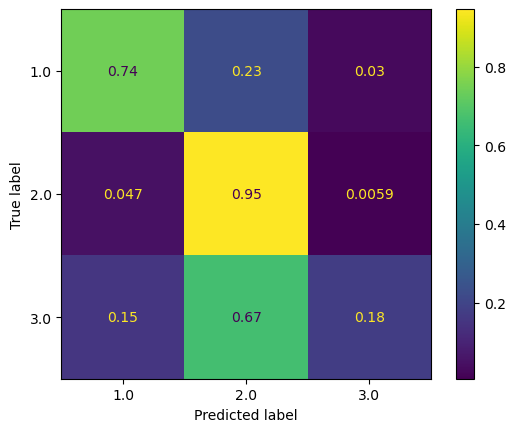

In [16]:
raw_rf = RandomForestClassifier(random_state=1)
train_model(raw_rf, X_train, X_test, y_train, y_test)

Classification report
               precision    recall  f1-score   support

         1.0       0.83      0.72      0.77       200
         2.0       0.81      0.96      0.88       512
         3.0       0.69      0.13      0.22        84

    accuracy                           0.81       796
   macro avg       0.78      0.60      0.62       796
weighted avg       0.80      0.81      0.78       796

Balanced accuracy score: 0.604327876984127


RandomForestClassifier(class_weight='balanced', random_state=1)

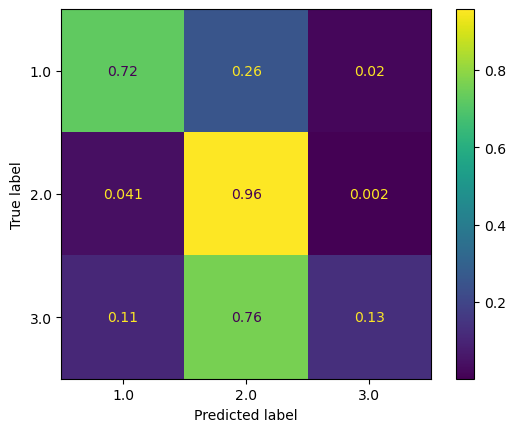

In [18]:
rf_balanced = RandomForestClassifier(random_state=1, class_weight="balanced")
train_model(rf_balanced, X_train, X_test, y_train, y_test)

In [ ]:
cols = [X_full.columns.get_loc(c) for c in lidar_features]
preprocessor = ColumnTransformer([
    ("scaled_pca", 
      Pipeline([
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12))]),
      cols)],
  remainder="passthrough")

Classification report
               precision    recall  f1-score   support

         1.0       0.66      0.61      0.64       200
         2.0       0.80      0.86      0.83       512
         3.0       0.42      0.27      0.33        84

    accuracy                           0.74       796
   macro avg       0.62      0.58      0.60       796
weighted avg       0.72      0.74      0.73       796

Balanced accuracy score: 0.5833792162698413


Pipeline(steps=[('imputer', SimpleImputer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaled_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.85))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('rf', RandomForestClassifier(random_state=1))])

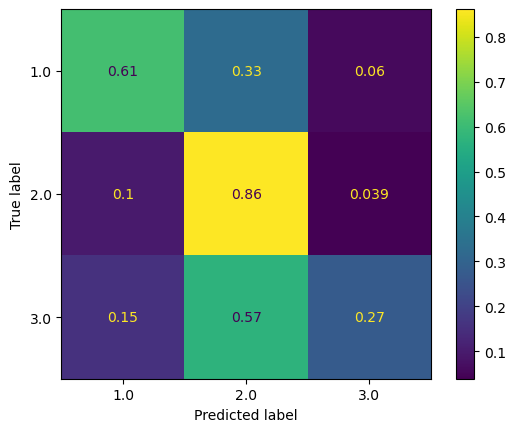

In [20]:
preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=1))
])
train_model(preprocess, X_train, X_test, y_train, y_test)

Classification report
               precision    recall  f1-score   support

         1.0       0.61      0.72      0.66       200
         2.0       0.84      0.75      0.79       512
         3.0       0.32      0.38      0.35        84

    accuracy                           0.70       796
   macro avg       0.59      0.62      0.60       796
weighted avg       0.73      0.70      0.71       796

Balanced accuracy score: 0.6176351686507936


Pipeline(steps=[('imputer', SimpleImputer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaled_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.85))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('smote', SMOTE(random_state=1)),
                ('rf', RandomForestClassifier(random_state=1))])

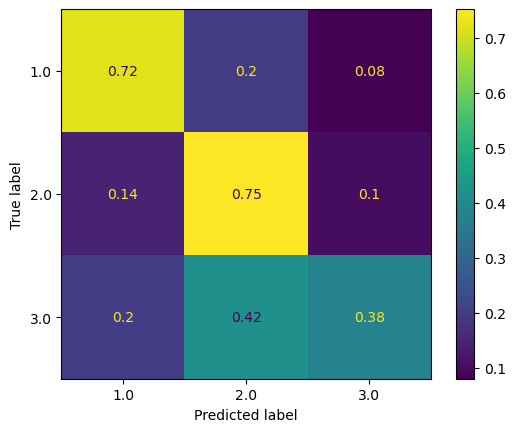

In [21]:
smote = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('rf', RandomForestClassifier(random_state=1))
])
train_model(smote, X_train, X_test, y_train, y_test)

## cross-validation

In [8]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [12]:
#get cv results
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='macro'),
           'recall' : make_scorer(recall_score, average='macro'),
           'f1_macro' : make_scorer(f1_score, average='macro'),
           'balanced_accuracy': make_scorer(balanced_accuracy_score)}

In [10]:
cols = [X_full.columns.get_loc(c) for c in lidar_features]
preprocessor = ColumnTransformer([
    ("scaled_pca", 
      Pipeline([
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12))]),
      cols)],
  remainder="passthrough")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=0.999, test=0.823) balanced_accuracy: (train=0.998, test=0.663) f1_macro: (train=0.999, test=0.695) precision: (train=0.999, test=0.782) recall: (train=0.998, test=0.663) total time=   1.3s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.806) balanced_accuracy: (train=1.000, test=0.636) f1_macro: (train=1.000, test=0.659) precision: (train=1.000, test=0.715) recall: (train=1.000, test=0.636) total time=   1.1s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.783) balanced_accuracy: (train=0.999, test=0.594) f1_macro: (train=1.

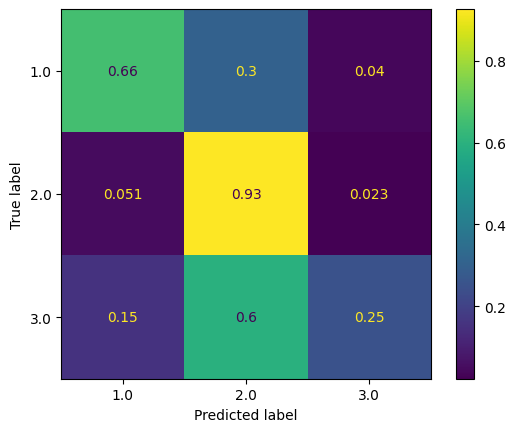

In [13]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit='balanced_accuracy', 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=0.999, test=0.827) balanced_accuracy: (train=0.998, test=0.631) f1_macro: (train=0.999, test=0.673) precision: (train=0.999, test=0.793) recall: (train=0.998, test=0.631) total time=   0.8s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=0.999, test=0.813) balanced_accuracy: (train=0.997, test=0.607) f1_macro: (train=0.998, test=0.641) precision: (train=0.999, test=0.752) recall: (train=0.997, test=0.607) total time=   0.8s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.781) balanced_accuracy: (train=1.000, test=0.580) f1_macro: (train=1.

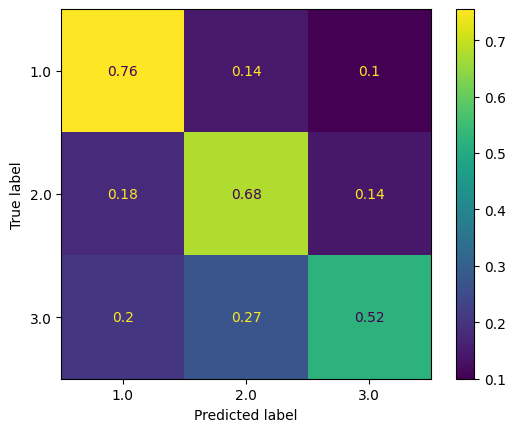

In [17]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(random_state=1, class_weight='balanced'))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.789) balanced_accuracy: (train=1.000, test=0.644) f1_macro: (train=1.000, test=0.659) precision: (train=0.999, test=0.678) recall: (train=1.000, test=0.644) total time=   1.6s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.784) balanced_accuracy: (train=1.000, test=0.669) f1_macro: (train=1.000, test=0.669) precision: (train=1.000, test=0.674) recall: (train=1.000, test=0.669) total time=   1.7s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.793) balanced_accuracy: (train=1.000, test=0.684) f1_macro: (train=1.

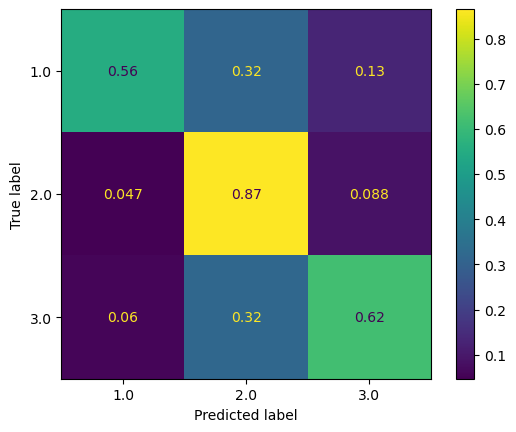

In [29]:
try:
    rf_cv_smote = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("smote", SMOTE(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv_smote,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv_smote = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.800) balanced_accuracy: (train=1.000, test=0.665) f1_macro: (train=1.000, test=0.679) precision: (train=1.000, test=0.697) recall: (train=1.000, test=0.665) total time=   1.6s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.782) balanced_accuracy: (train=1.000, test=0.675) f1_macro: (train=1.000, test=0.670) precision: (train=1.000, test=0.673) recall: (train=1.000, test=0.675) total time=   1.6s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.773) balanced_accuracy: (train=1.000, test=0.646) f1_macro: (train=1.

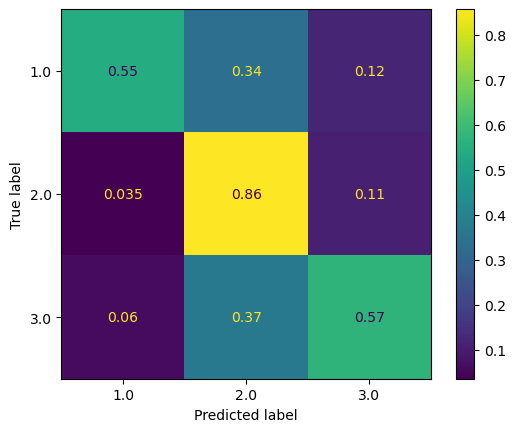

In [30]:
try:
    rf_cv_ad = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("ad", ADASYN(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv_ad,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv_ad = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.795) balanced_accuracy: (train=1.000, test=0.657) f1_macro: (train=1.000, test=0.675) precision: (train=0.999, test=0.701) recall: (train=1.000, test=0.657) total time=   1.5s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.777) balanced_accuracy: (train=1.000, test=0.652) f1_macro: (train=1.000, test=0.652) precision: (train=1.000, test=0.657) recall: (train=1.000, test=0.652) total time=   1.5s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.781) balanced_accuracy: (train=0.999, test=0.653) f1_macro: (train=1.

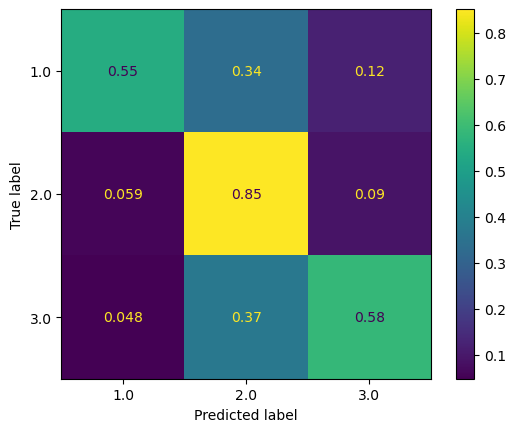

In [31]:
try:
    rf_cv_bsmote = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("preprocess", preprocessor),
        ("bsmote", BorderlineSMOTE(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv_bsmote,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy",
        return_train_score=True
    )
    
    rf_cv_bsmote = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

In [ ]:
#pca test
try: 
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("pca", PCA(n_components=0.85)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=sgkf,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train, X_test, y_train, y_test, groups_train)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

## MLP

In [9]:
cols = [X_full.columns.get_loc(c) for c in lidar_features]
pca_lidar = ColumnTransformer([
    ("pca", 
      Pipeline([
        ("pca", PCA(n_components=12))]),
      cols)],
  remainder="passthrough")

In [10]:
def train_mlp(pipeline, X_train, X_test, y_train, y_test, groups=None):
    param_grid = {
    "clf__model__hidden_layers": [(256,128,64), (128,64,32)],
    "clf__model__learning_rate": [1e-4],
    "clf__epochs":        [50,100],
    "clf__batch_size":    [32, 64],
    }

    if groups is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    else:
        cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)

    gscv = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=1,
        verbose=2,
        refit="balanced_accuracy",
        return_train_score=True
    )
    if groups is None:
        gscv.fit(X_train, y_train)
    else:
        gscv.fit(X_train, y_train, groups=groups)

    std = gscv.cv_results_["std_test_accuracy"][gscv.best_index_]
    print(f"Best CV BA: {gscv.best_score_:.3f}, ± {std:.3f}")
    print("train score", gscv.cv_results_['mean_train_accuracy'], "vs. cv test score", gscv.cv_results_['mean_test_accuracy'])
    print("Best params:")
    for k, v in gscv.best_params_.items():
        print(f"  {k}: {v}")
    
    mean_f1 = np.mean(gscv.cv_results_["mean_test_f1_macro"])
    std_f1 = np.std(gscv.cv_results_["std_test_f1_macro"])
    mean_ba = np.mean(gscv.cv_results_["mean_test_balanced_accuracy"])
    std_ba = np.std(gscv.cv_results_["std_test_balanced_accuracy"])
    mean_oa = np.mean(gscv.cv_results_["mean_test_accuracy"])
    std_oa = np.std(gscv.cv_results_["std_test_accuracy"])
    print(f"Mean CV accuracy: {mean_oa:.3f}, ± {std_oa:.3f}")
    print(f"Mean CV BA: {mean_ba:.3f}, ± {std_ba:.3f}")
    print(f"Mean CV f1: {mean_f1:.3f}, ± {std_f1:.3f}")

    test_acc = gscv.score(X_test, y_test)
    print(f"Test set accuracy: {test_acc:.3f}")

    best_model = gscv.best_estimator_        
    y_pred     = best_model.predict(X_test)
    print("Classification report\n", classification_report(y_test, y_pred))
    print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

def build_mlp(hidden_layers=(64,32,16), meta=None, **kwargs):
    model = Sequential([
        Input(shape=(meta["n_features_in_"],)),])
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  10.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=   9.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  10.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=   9.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=   9.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   8.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__lea

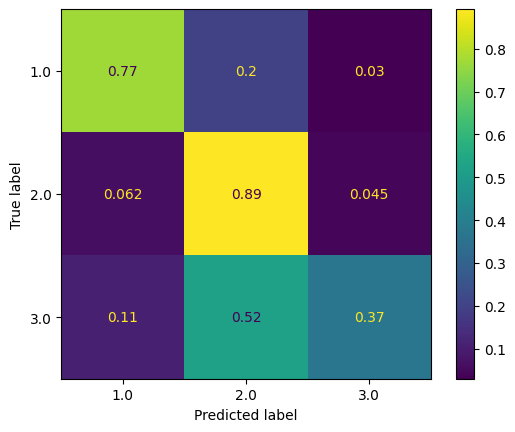

In [18]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train, X_test, y_train, y_test, groups_train)

## Balanced 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  16.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  16.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  17.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  16.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  13.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  11.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__lea

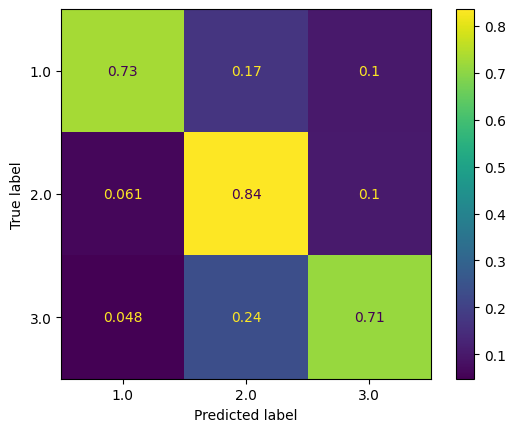

In [13]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv_smote = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("smote", SMOTE(sampling_strategy='minority', random_state=1)),
    ("clf", clf)
])

train_mlp(mlp_cv_smote, X_train, X_test, y_train, y_test, groups_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  12.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  13.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  13.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  13.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  13.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  11.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__lea

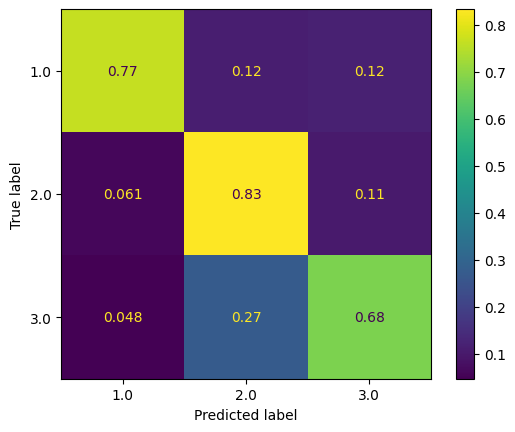

In [14]:
mlp_cv_ad = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("smote", ADASYN(sampling_strategy='minority', random_state=1)),
    ("clf", clf)
])

train_mlp(mlp_cv_ad, X_train, X_test, y_train, y_test, groups_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  15.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  15.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  17.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  17.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(256, 128, 64), clf__model__learning_rate=0.0001; total time=  16.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  13.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__lea

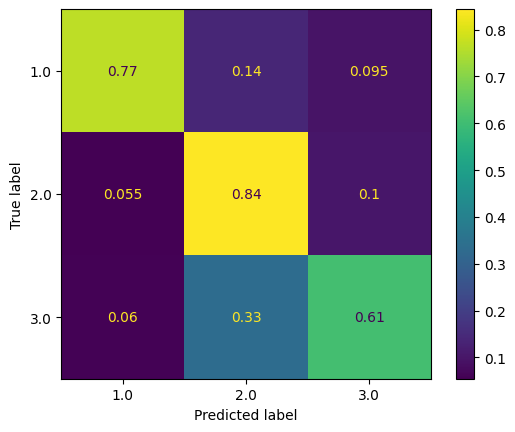

In [15]:
mlp_cv_bsmote = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", pca_lidar),
    ("bsmote", BorderlineSMOTE(sampling_strategy='minority', random_state=1)),
    ("clf", clf)
])

train_mlp(mlp_cv_bsmote, X_train, X_test, y_train, y_test, groups_train)

In [40]:
end_time = time.time()
end_mem = process.memory_info().rss / (1024 ** 2)  # in MB

print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Start memory usage: {start_mem:.2f} MB")
print(f"End memory usage: {end_mem:.2f} MB")
print(f"Peak memory usage: {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024:.2f} MB")

Total execution time: 2121.76 seconds
Start memory usage: 593.98 MB
End memory usage: 2594.59 MB
Peak memory usage: 2696.23 MB
